# <font color='12284A' style="font-family: andale mono, monospace; font-size: 28px; text-transform: uppercase">Drum Audio Sample Classifier - Model<font><a class='anchor' id='top'></a>
This portion of the application is used to create the model. It imports, and parses the dataset, creates and fits the model, and finally saves the model to be used by the "drum_prediction" jupyter notebook.
    
I would like the recognize and thank Dr. Papia Nandi for her article "CNNs for Audio Classification". Citation comments are included in code snippets directly adapted from her work and proper citations will be included in Task documentation.

In [1]:
#Imports Modules
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
from sklearn.preprocessing import normalize
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Get acbsolute path of project
abs_path = os.getcwd()

# Imports csv of dataset metadata
df = pd.read_csv(abs_path + "/dataset/samples_metadata.csv")

# Defines variables that may be changes in the future

# Number of spectrogram frames to use
LENGTH = 22050

# Drum Type Dictionary with indices
drum_types = {
    'clap': 0,
    'closedhat': 1,
    'kick': 2,
    'openhat': 3,
    'snare': 4,
}

In [3]:
# Converts Audio Samples in single Numpy Array to train model

# Gets relative path to audio samples for dataset
samples = abs_path + "/dataset/samples/"

# Create blank lists to fill
samples_data = []
samples_visual_data = []
samples_data_type = []

for sample in sorted(os.listdir(samples)):
    # Blank arrays of zeros to be overwritten by sample data, required to make all sample arrays the same size
    # Array Dimensions are as follows: D1: Pitch Slices (513), D2: Time samples (LENGTH), and D3: value of power/amplitude
    # D3 is duplicated across 3 values in the model version since CNNs were made with RGB (3) image values in mind. It's
    # simpler to make the CNN Model think it is a RGB image than try and make it work for audio specifically
    
    # Load, Trim, and resample the audio file
    audio, sr = librosa.load(samples+sample, sr=22050)
    audio, _ = librosa.effects.trim(audio, top_db=50)
    audio = librosa.resample(y=audio, orig_sr=sr, target_sr=22050)
    
    if len(audio) < LENGTH:
        audio = np.pad(audio, (0, LENGTH - len(audio)))
    else:
        audio = audio[:LENGTH]

    # audio is now LENGTH long: shape into (LENGTH, 1)
    audio = audio.reshape((LENGTH, 1))
    # Adds audio samples into samples_data
    samples_data.append(audio)
    
    # Adds audio samples type of drum to samples_data_type
    samples_data_type.append([val for key,val in drum_types.items() if key in sample])

# Convert Lists to Numpy Arrays
samples_data = np.array(samples_data)
samples_data_type = np.array(samples_data_type)

This is our preprocessing step. Anything we do here must be replicated exactly when we want to sample the final model. Except for the visuals related stuff, which is just for testing and sanity checking before we train the model.

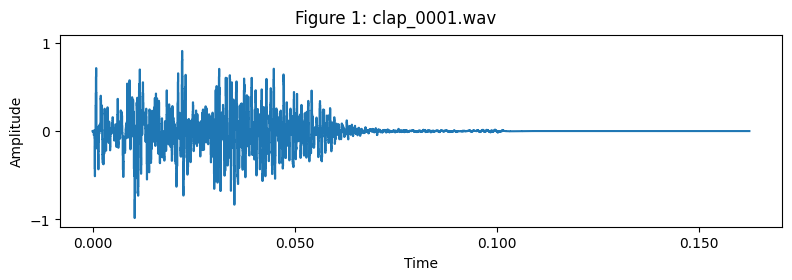

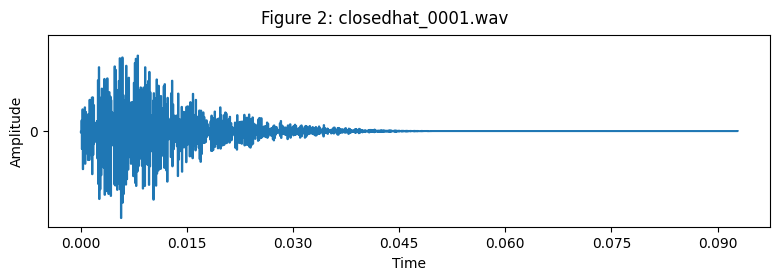

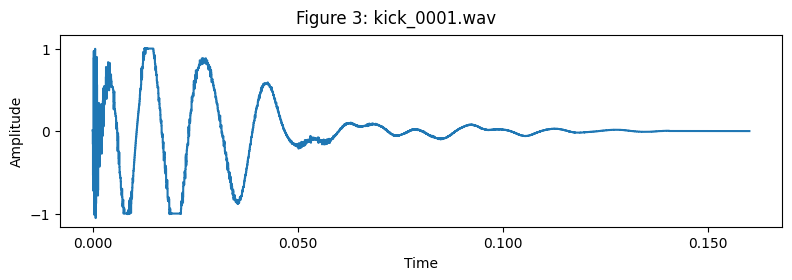

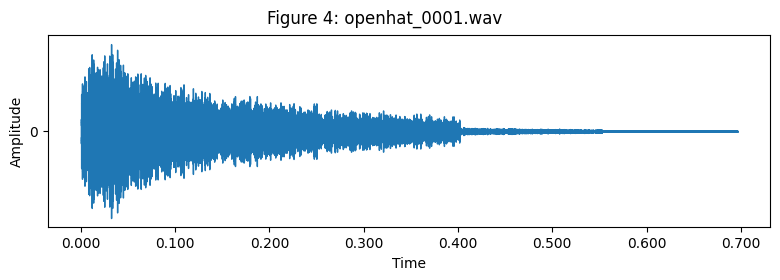

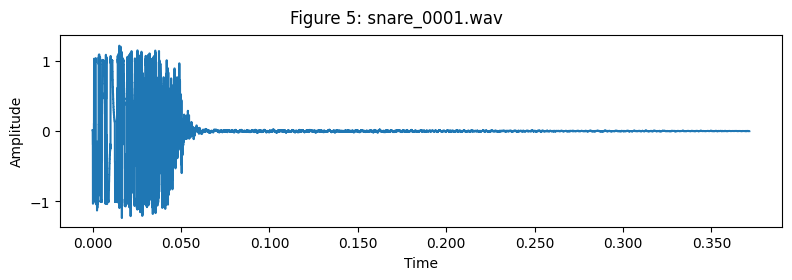

In [4]:
# Outputs Waveform of the first of each Drum Type, conveys amplitude over time
for i, drum in enumerate(drum_types):
    y, sr = librosa.load(samples + drum + '_0001.wav')

    y,z = librosa.effects.trim(y, top_db=50)
    y = librosa.resample(y=y, orig_sr=sr, target_sr=22050)

    plt.figure(figsize=(8, 3))
    plt.suptitle("Figure " + str(i+1) + ": " + drum + '_0001.wav',x=0.5, y=0.915,fontsize=12)
    plt.xlabel("Time")
    plt.ylabel('Amplitude')
    
    plt.xticks(np.arange(0, 1, 1))
    plt.yticks(np.arange(-2, 2, 1))
    plt.tight_layout(pad=1.0)
    
    librosa.display.waveshow(y, sr=sr)

In [32]:
# Split once to get the test and training set
X_train, X_test, y_train, y_test = train_test_split(samples_data, samples_data_type, test_size=0.25, random_state=123)

# Split twice to get the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)

This splits the dataset into 3 sets: training (56%), validation (19%), and test (25%)

In [ ]:
# Custom layers

class TripleChannel(layers.Layer):
    def call(self, x):
        return tf.concat([x, x, x], axis=-1)

In [44]:
# Adapted from "CNNs for Audio Classification" by Papia Nandi, 2021

# Adds layers to model
# Conv2D Layers are important for CNNs to learn audio spacial information
# Max Pooling and Dropout Layers help avoid overfitting

model = models.Sequential()

# Raw waveform input
model.add(layers.Input(shape=(LENGTH, 1)))

# Learned filterbank (Conv1D)
# 128 filters
# Kernel_size & stride mimic window/hop of STFT-like transform
model.add(layers.Conv1D(
    filters=128, 
    kernel_size=512, 
    strides=256, 
    padding='same',
    activation='relu'
))

model.add(layers.Dropout(0.1))

# Transpose: (batch, time, 128) → (batch, 128, time)
model.add(layers.Permute((2, 1)))

# Add channel dim: (batch, 128, time, 1)
model.add(layers.Reshape((128, -1, 1)))

model.add(TripleChannel())

# Now filters=128, time≈ceil(LENGTH/256)
# We compute the time dimension for input_shape
time_frames = int(np.ceil(LENGTH / 256))

# Rest of the model stays the same

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, time_frames, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(len(drum_types), activation='softmax'))

Normalization layer is included in the model so that normalization parameters are stored inside the model itself.
BatchNormalization layers were added for stability, which seems to have helped a lot.

In [45]:
# Model is compiled. Adam is used to have a automatic learning rate
# Sparse Categorical Crossentropy is used since there are multiple drum types, but only one drum type per drum
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [46]:
# Fits model
history = model.fit(X_train, y_train, epochs=30, validation_data= (X_val, y_val))

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6049 - loss: 1.9650 - val_accuracy: 0.5087 - val_loss: 1.5307
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6697 - loss: 1.4361 - val_accuracy: 0.0466 - val_loss: 2.2213
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7299 - loss: 1.0841 - val_accuracy: 0.1204 - val_loss: 2.6504
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7681 - loss: 0.9904 - val_accuracy: 0.0913 - val_loss: 3.9268
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7714 - loss: 0.8602 - val_accuracy: 0.0913 - val_loss: 4.8188
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7902 - loss: 0.8161 - val_accuracy: 0.0971 - val_loss: 5.3466
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7966 - loss: 0.8195 - val_accuracy: 0.0466 - val_loss: 5.6082
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8122 - loss: 0.8653 - val_accuracy: 0.0971 - v

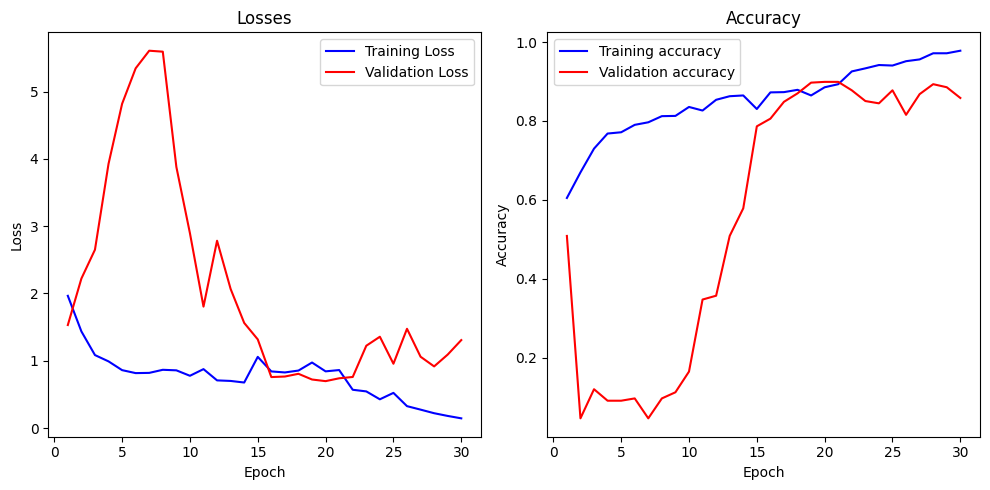

{'accuracy': [0.6049222946166992, 0.6696891188621521, 0.7299222946166992, 0.7681347131729126, 0.7713730335235596, 0.7901554107666016, 0.7966321110725403, 0.8121761679649353, 0.8128238320350647, 0.8354922533035278, 0.8264248967170715, 0.8536269664764404, 0.8626943230628967, 0.8646373152732849, 0.8303108811378479, 0.8724093437194824, 0.8730570077896118, 0.8788859844207764, 0.8646373152732849, 0.8853626847267151, 0.8931347131729126, 0.9255181550979614, 0.9332901835441589, 0.9417098164558411, 0.9404144883155823, 0.9514248967170715, 0.9559585452079773, 0.9715026021003723, 0.9715026021003723, 0.977979302406311], 'loss': [1.96495521068573, 1.4360679388046265, 1.0841232538223267, 0.9904195070266724, 0.8602358102798462, 0.8160510063171387, 0.8194655776023865, 0.8653208613395691, 0.857349693775177, 0.7763529419898987, 0.8753053545951843, 0.708005964756012, 0.6997019648551941, 0.6761300563812256, 1.057430386543274, 0.8410588502883911, 0.8259943127632141, 0.8540714979171753, 0.9733633995056152, 0.

In [48]:
# Adapted from "CNNs for Audio Classification" by Papia Nandi, 2021
# Nandi originally adapted from Deep Learning with Python by Francois Chollet, 2018

# Outputs graphs of Losses and Accuracy of model.
history_dict=history.history
loss_values=history_dict['loss']
accuracy_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_accuracy_values=history_dict['val_accuracy']
epochs=range(1, len(loss_values)+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

ax1.plot(epochs,loss_values,'blue',label='Training Loss')
ax1.plot(epochs,val_loss_values,'red', label='Validation Loss')
ax1.set_title('Losses')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs,accuracy_values,'blue', label='Training accuracy')
ax2.plot(epochs,val_accuracy_values,'red',label='Validation accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

print(history.history)
# Print final accuracy and validation accuracy:
print('Final Accuracy: ', accuracy_values[-1])
print('Final Validation Accuracy: ', val_accuracy_values[-1])

In [31]:
# Saves model to be used by the prediction Jupyter Notebook
model.save('saved_model/model_raw_last.keras')